In [1]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
import xgboost as xgb
seed =45
% matplotlib inline

In [2]:
path = ''
#path = ''
train = pd.read_csv(path+'train.csv',na_values=-1)
test = pd.read_csv(path+'test.csv',na_values=-1)
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [3]:
train.head(2).T

,0,1
id,7.000000,9.000000
target,0.000000,0.000000
ps_ind_01,2.000000,1.000000
ps_ind_02_cat,2.000000,1.000000
ps_ind_03,5.000000,7.000000
ps_ind_04_cat,1.000000,0.000000
ps_ind_05_cat,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000
ps_ind_07_bin,1.000000,0.000000
ps_ind_08_bin,0.000000,1.000000


0    573518
1     21694
Name: target, dtype: int64

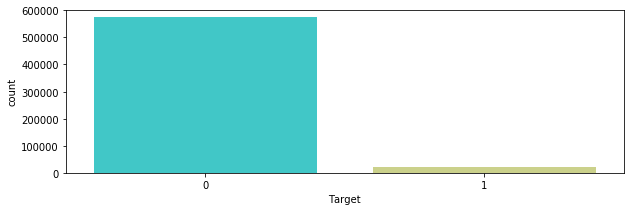

In [4]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

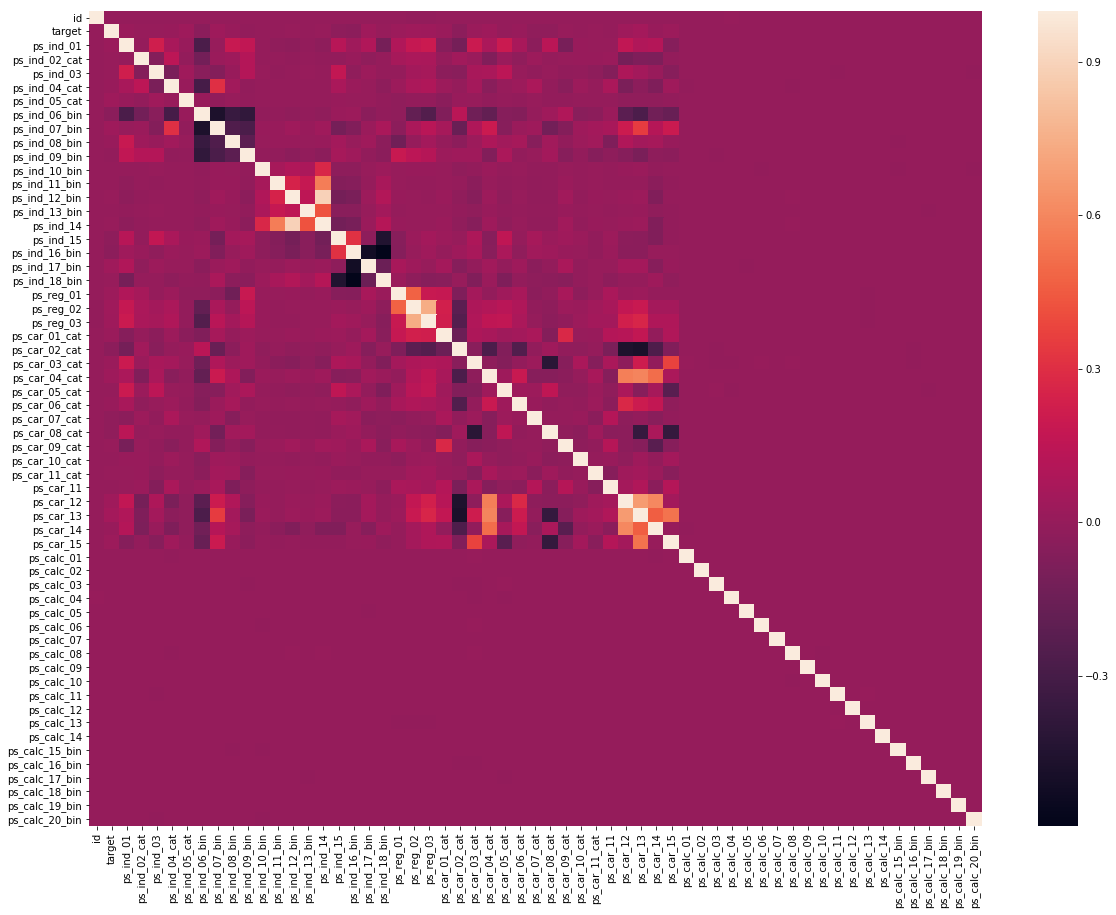

In [5]:
cor = train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(cor)

In [6]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)
test = test.drop(ps_cal,axis=1)
train.shape

(595212, 39)

In [7]:
train['target'] = train['target'].astype('category')

In [8]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
target,0,NaN
ps_ind_01,0,0.0
ps_ind_02_cat,216,307.0
ps_ind_03,0,0.0
ps_ind_04_cat,83,145.0
ps_ind_05_cat,5809,8710.0
ps_ind_06_bin,0,0.0
ps_ind_07_bin,0,0.0
ps_ind_08_bin,0,0.0


In [9]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [10]:
missing_value(train)
missing_value(test)

In [11]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


In [12]:
for c in cat_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [13]:
bin_col = [col for col in train.columns if 'bin' in col]
print(bin_col)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


In [14]:
for c in bin_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 
    
def category_col(df):
    c_col = df.columns
    to_cat_col =[]
    for i in c_col:
        if df[i].nunique()<=104:
            to_cat_col.append(i)
    return to_cat_col


tot_cat_col = category_col(train)
other_cat_col = [c for c in tot_cat_col if c not in cat_col+ bin_col]
other_cat_col

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15']

In [15]:
ot_col = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15','ps_car_11']
for c in ot_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [16]:
num_col = [c for c in train.columns if c not in tot_cat_col]
#num_col.append('ps_car_15')
#train['ps_car_15'] = train['ps_car_15'].astype('float32')
#test['ps_car_15'] = test['ps_car_15'].astype('float32')
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [17]:
def transform_df(df):
    df = pd.DataFrame(df)
    dcol= [c for c in train.columns if train[c].nunique()>2]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 2 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df

In [18]:
train = transform_df(train)
test = transform_df(test)

In [19]:
X = train.drop(['target','id'],axis=1)
y = train['target'].astype('category')
x_test = test.drop('id',axis=1)

In [20]:
"""xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=500,objective='binary:logistic',
                          min_child_weight=1,scale_pos_weight=1)
param = {'max_depth':[3,4,7,10],
         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],
         'min_child_weight':[1,3,5,7,10],
         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],
         'reg_alpha':[1,1.5,3,8,10,12,15],
         'gamma':[0.1,0.5,1,2,5,10],
         'scale_pos_weight':[0.5,1,2,3,5,10],
        'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],
        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1]}
clf = RandomizedSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=3)

clf.fit(X,y)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_)) """

"xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=500,objective='binary:logistic',\n                          min_child_weight=1,scale_pos_weight=1)\nparam = {'max_depth':[3,4,7,10],\n         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],\n         'min_child_weight':[1,3,5,7,10],\n         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],\n         'reg_alpha':[1,1.5,3,8,10,12,15],\n         'gamma':[0.1,0.5,1,2,5,10],\n         'scale_pos_weight':[0.5,1,2,3,5,10],\n        'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],\n        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1]}\nclf = RandomizedSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=3)\n\nclf.fit(X,y)\nprint('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_)) "

In [21]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,num_rounds=100,max_depth=4):
    params = {
        'objective':'binary:logistic',        
        'max_depth':max_depth,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model

In [22]:
kf = StratifiedKFold(n_splits=5,random_state=seed)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=700,eta=0.1)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1

1 of KFold 5
[0]	train-auc:0.587565	test-auc:0.587144
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.642588	test-auc:0.633009
[100]	train-auc:0.653956	test-auc:0.639221
[150]	train-auc:0.65842	test-auc:0.640999
[200]	train-auc:0.661552	test-auc:0.641665
Stopping. Best iteration:
[189]	train-auc:0.660694	test-auc:0.641797

2 of KFold 5
[0]	train-auc:0.592591	test-auc:0.587063
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.641903	test-auc:0.631787
[100]	train-auc:0.653689	test-auc:0.639321
[150]	train-auc:0.657664	test-auc:0.641109
[200]	train-auc:0.660658	test-auc:0.642245
[250]	train-auc:0.662966	test-auc:0.642923
[300]	train-auc:0.665319	test-auc:0.642742
Stopping. Best iteration:
[257]	train-auc:0.663285	test-auc:0.642957

3 of KFold 5
[0]	train-auc:0.587402	test-au

In [23]:
print(cv_score)
print('Mean cv_score',np.mean(cv_score))

[0.641797, 0.642957, 0.641659, 0.646494, 0.636539]
Mean cv_score 0.6418891999999999


In [24]:
pred_xgb = pred_test_full/kf.n_splits

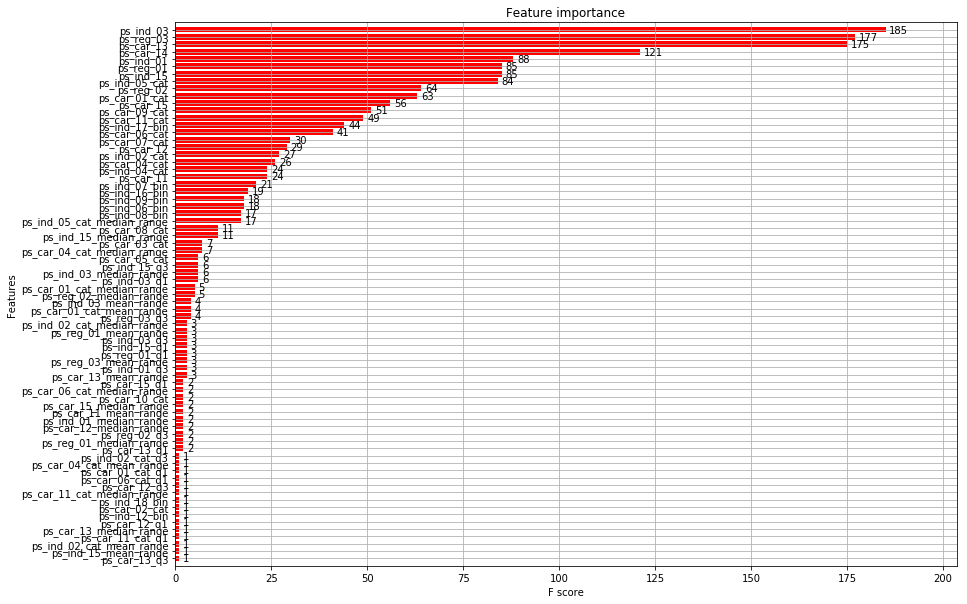

In [25]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

In [26]:
y_pred = pred_xgb
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
submit.to_csv('xgb_porto.csv',index=False)